In [1]:
# -*- coding: utf-8 -*-
import cv2
import os
import sys
import time
sys.path.insert(0,"/world/data-gpu-112/liliang/pytorch-reid")
import random
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb
import pickle
from collections import OrderedDict, Counter


In [2]:
def aggregate(images_lst, pred_logits_lst, pred_labels_lst, id_lst):
    id2infos = OrderedDict()
    id2img = []
    for i, label in enumerate(id_lst):
        if not label in id2infos:
            id2infos[label] = {"logits": [pred_logits_lst[i]], "pred_labels": [pred_labels_lst[i]]}
            id2img.append(images_lst[i])
        else:
            id2infos[label]["logits"].append(pred_logits_lst[i])
            id2infos[label]["pred_labels"].append(pred_labels_lst[i])
    return id2img, id2infos

def cal_age_xulie(id2infos):
    # scope_xulie could be changed
    scope_xulie = ["0-1", "2-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-40", "41-50", "51-60", "61-80", "80-100"]
    record_dict = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0, "10":0, "11":0}
    refer = [0.5, 2.5, 8, 13, 18, 23, 28, 35, 45, 55, 70, 90]
    id2age = []
    record_dict = []
    for label, infos in id2infos.items():
        logits_lst = np.asarray(infos["logits"])
        age = np.sum(np.sum(logits_lst, axis=0) * np.asarray(refer)) / len(logits_lst)
        id2age.append(age)
        id2logits.append()
        for i, age_scope in enumerate(scope_xulie):
            lower_bound, upper_bound = map(int, age_scope.split("-"))
            if lower_bound < age < upper_bound:
                record_dict[str(i)] += 1
    return id2age, record_dict

def cal_age_online(id2infos):
    scope = ["0-1", "2-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-40", "41-50", "51-60", "61-80", "80+"]
    record_dict = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0, "10":0, "11":0}
    id2age = []
    record_dict = []
    for label, infos in id2infos.items():
        label_lst = infos["pred_labels"]
        id_age = max(label_lst, key=label_lst.count)
        id2age.append(id_age)
        record_dict[str(id_age)] += 1
    return id2age, record_dict


def _get_pred(model, json_path, task_index, pred_all=False):
    def _softmax(x):
        exp_x = np.exp(x)
        softmax_x = exp_x / np.sum(exp_x)
        return softmax_x 
    
    label_set = set()
    f = open(json_path, "r")
    record_dict = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0, "10":0, "11":0}
    images = []
    pred_logits = []
    pred_labels = []
    ids = []
    for line in f:
        if len(line) < 40:
            continue
        path, info = line.split("\t")
        info = json.loads(info)
        label = info["label"]
        if not pred_all and label in label_set:
            continue
        else:
            label_set.add(label)
            
        ids.append(label)
        image = cv2.imread(path)
        image = cv2.resize(image, (128,256)) 
        image = np.expand_dims(image, axis=0)
        
        
        logits = model.predict(image)[task_index]
        logits = _softmax(np.asarray(logits))[0]
        pred_label = np.argmax(logits)
        
        images.append(image)
        pred_logits.append(logits)
        pred_labels.append(pred_label) # imshow展示原来的label
        record_dict[str(pred_label)] += 1
            
    return images, pred_logits, pred_labels, record_dict, ids

def run_eval(task_index, pretrain_snapshots, pred_all=False):
    from auto_deploy.predictor import Predictor
    print ("model restored form: %s" %pretrain_snapshot)
    model = Predictor(gpu=0, input_size=(128, 256), model_path=pretrain_snapshot,
                      preprocess_dict={"norm_lambda": "lambda x: x", "color_mode": "None"})
    # forward
    imgs, pred_logits, pred_labels, record_dict, ids = _get_pred(model, json_path, task_index, pred_all)
    
    if pred_all:
        imgs, id2infos = aggregate(images_lst, pred_logits_lst, pred_labels_lst, id_lst)
        pred_logits = []*len(pred_labels) # for compatibility 
        pred_labels, record_dict = cal_age_online(id2infos)
        pred_labels, record_dict = cal_age_xulie(id2infos)
    
    return imgs, pred_logits, pred_labels, record_dict

In [27]:
task_idx = {"age":1, "bag":2, "gender":3, "orient":4}
age_scpoe_mapping = {0:"0-1", 1:"2-5", 2:"6-10", 3:"11-15", 4:"16-20", 5:"21-25",
                     6:"26-30", 7:"31-40", 8:"41-50", 9:"51-60", 10:"61-80", 11:"80+"}
scope = ["0-1", "2-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-40", "41-50", "51-60", "61-80", "80+"]
base_path = "/world/data-gpu-112/liliang/pytorch-output-mt/"

json_path = "/world/data-c26/liliang/anta_json/entrance_16-22.json"
dataset_name = json_path.split("/")[-1].split(".")[0]

pretrain_snapshots = [
#     "/world/data-c7/xiaoyouchang/resnet_50_ibn_a_20190409_163335.pt",
#     "v4-all1-2.0–4.0-1-1-1.5tw_new",
#     "v4-all1-2.5–3.5-1-1-1.1-1.5tw_new",
#     "v4-all1-2.0–3.0-1-1-1.2-1.5tw_new",
#     "v4-all1-2.0–3.0-1-1-2.0-1.5tw_new",
    "v5++_v4-all1-3–4-1-1-1–1-1.5tw",
]



In [28]:
def get_latest_model(base_path, pretrain_dir):
    model_lst = []
    pretrain_dir = os.path.join(base_path, pretrain_dir)
    for filename in os.listdir(pretrain_dir):
        if filename.endswith("pt") or filename.endswith("onnx"):
            model_lst.append(filename)
    assert len(model_lst)>0, "There is no freeze model in dir."
    model_lst = sorted(model_lst, key=lambda x:int("".join(x.split(".")[0].split("_")[-2:])), reverse=True)
    latest_model = os.path.join(pretrain_dir, model_lst[0])
    if len(model_lst)>1:
        for model in model_lst[1:]:
            os.remove(os.path.join(pretrain_dir, model))
    return latest_model

for pretrain_snapshot in pretrain_snapshots:
    pretrain_snapshot = get_latest_model(base_path, pretrain_snapshot) if not pretrain_snapshot.startswith("/world") else pretrain_snapshot
    model_name = pretrain_snapshot.split("/")[-2]
    imgs, pred_logits, pred_labels, record_dict = run_eval(task_idx["age"], pretrain_snapshot)
    with open('/world/data-c26/liliang/attr_pickle/%s.pkl'%dataset_name, 'wb') as f:
        pickle.dump(imgs, f)
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_pred_logits.pkl'%(dataset_name, model_name), 'wb') as f:
        pickle.dump(pred_logits, f) 
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_pred_labels.pkl'%(dataset_name, model_name), 'wb') as f:
        pickle.dump(pred_labels, f)  
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_record_dict.pkl'%(dataset_name, model_name), 'wb') as f:
        pickle.dump(record_dict, f)

model restored form: /world/data-gpu-112/liliang/pytorch-output-mt/v5++_v4-all1-3–4-1-1-1–1-1.5tw/resnet_50_ibn_a_20190916_104930.pt


In [25]:
dataset_name = "entrance_16-22"
model_names = ["xiaoyouchang",
               "v4-all1-2.0–4.0-1-1-1.5tw_new",
               "v5++_v4-all1-3–4-1-1-1–1-1.5tw",
#                "v4-all1-2.0–3.0-1-1-2.0-1.5tw_new",
#                "v4-all1-2.0–3.0-1-1-1.2-1.5tw_new",
               "v4-all1-2.5–3.5-1-1-1.1-1.5tw_new",
              ]
pred_logits_lst = []
pred_labels_lst = []
record_dict_lst = []
with open('/world/data-c26/liliang/attr_pickle/%s.pkl'%dataset_name, 'rb') as f:
    imgs = pickle.load(f)
for model_name in model_names:
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_pred_logits.pkl'%(dataset_name, model_name), 'rb') as f:
        pred_logits_lst.append(pickle.load(f))
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_pred_labels.pkl'%(dataset_name, model_name), 'rb') as f:
        pred_labels_lst.append(pickle.load(f))
    with open('/world/data-c26/liliang/attr_pickle/%s_%s_record_dict.pkl'%(dataset_name, model_name), 'rb') as f:
        record_dict_lst.append(pickle.load(f))

total ids: 9756


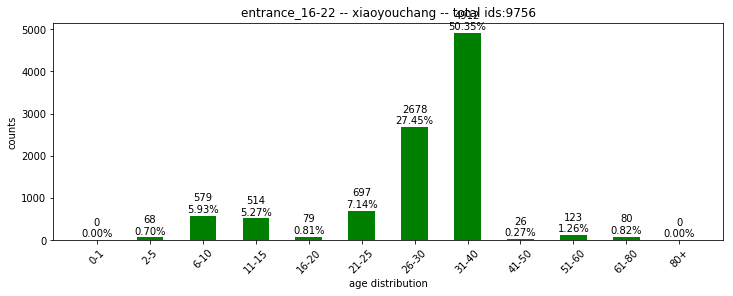

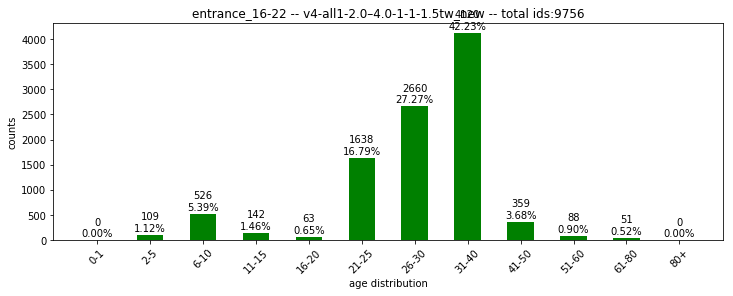

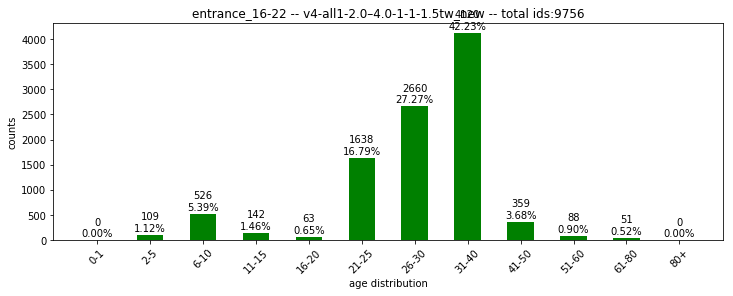

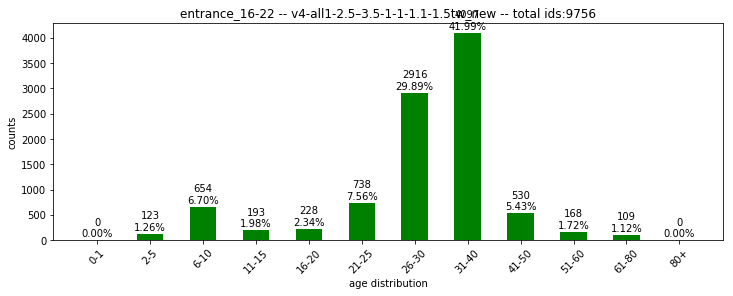

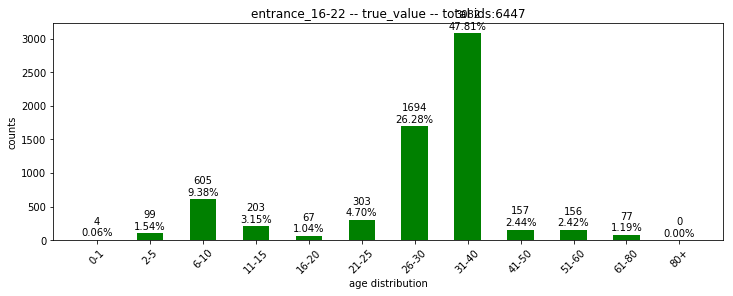

/usr/local/python-3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


total diff: 4711


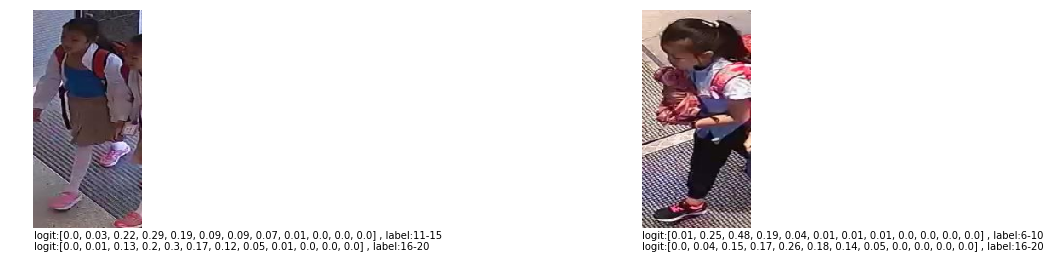

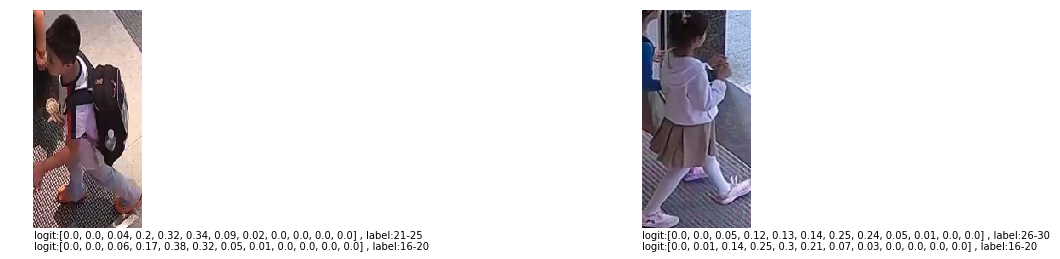

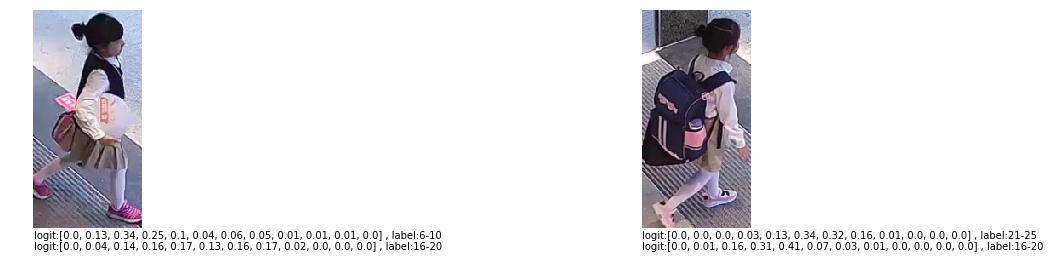

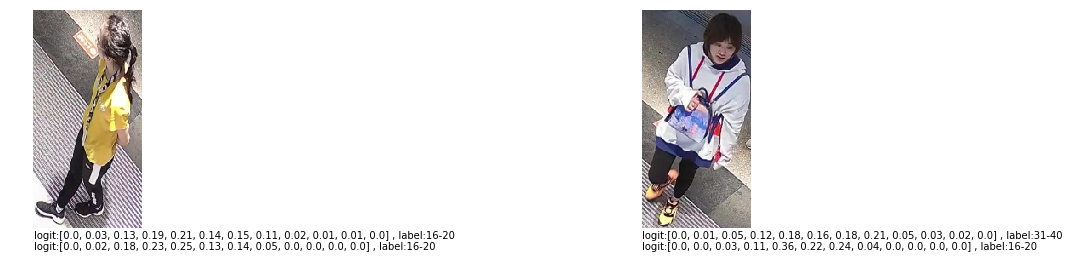

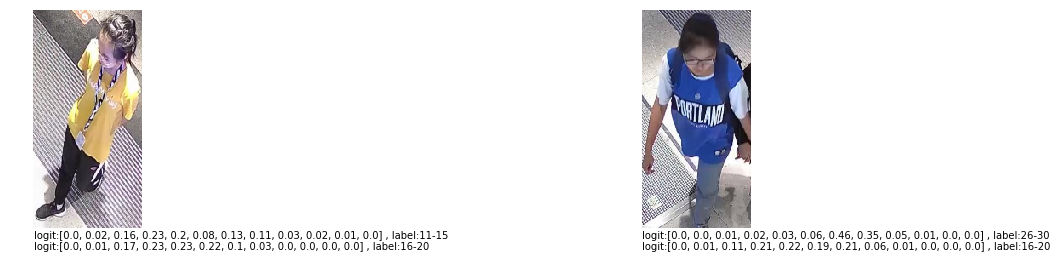

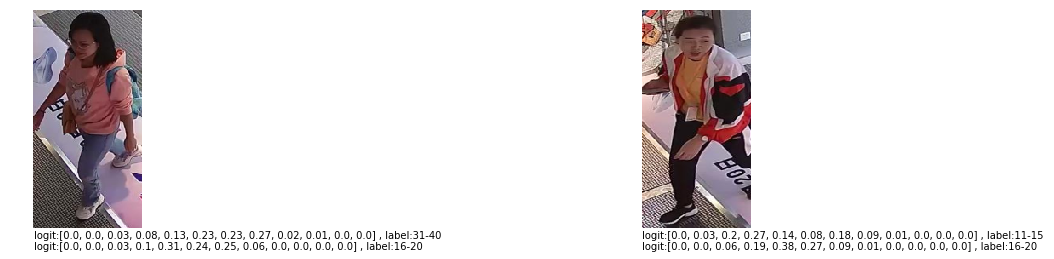

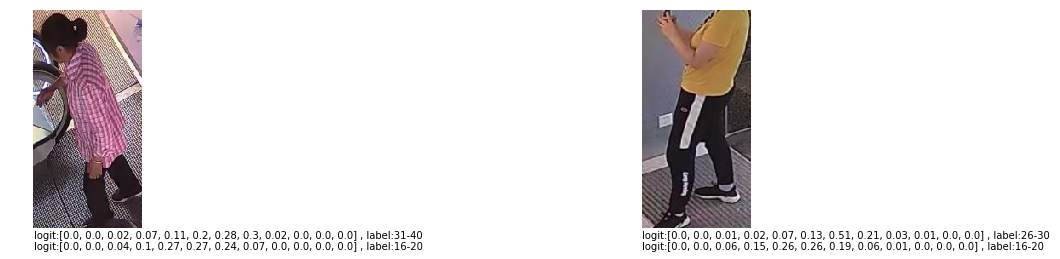

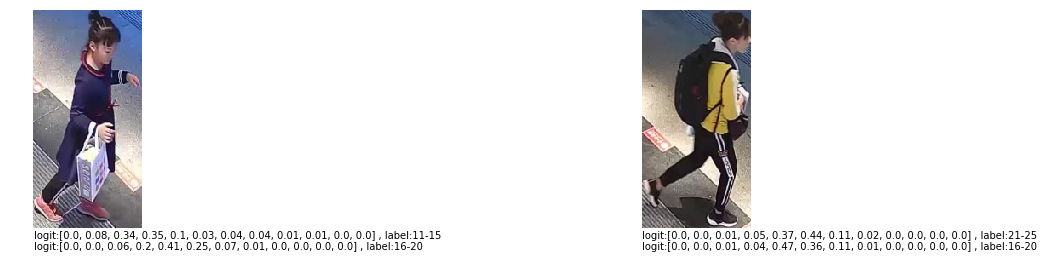

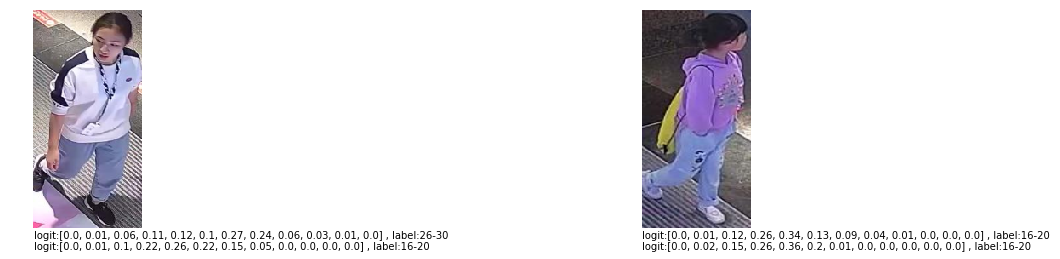

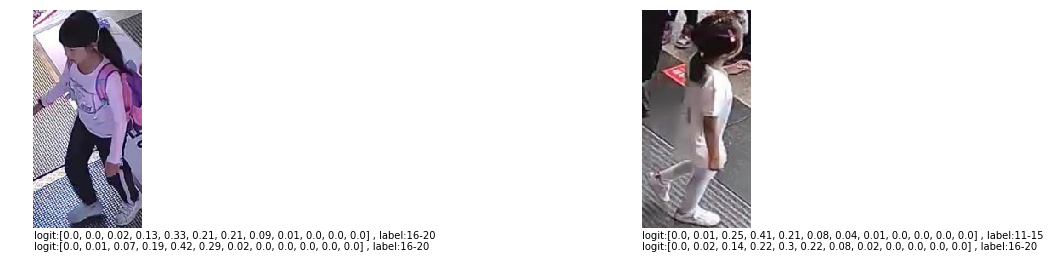

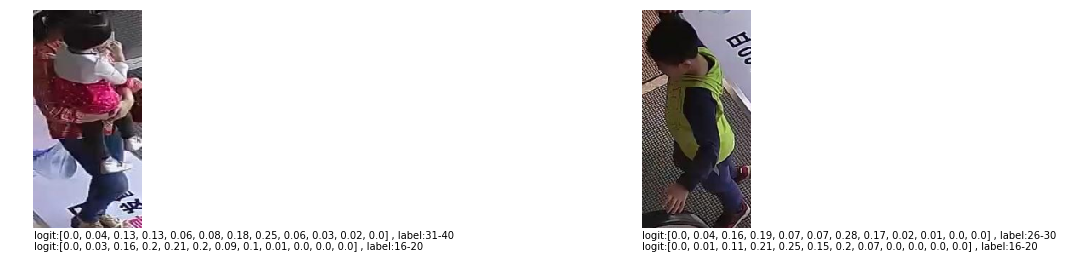

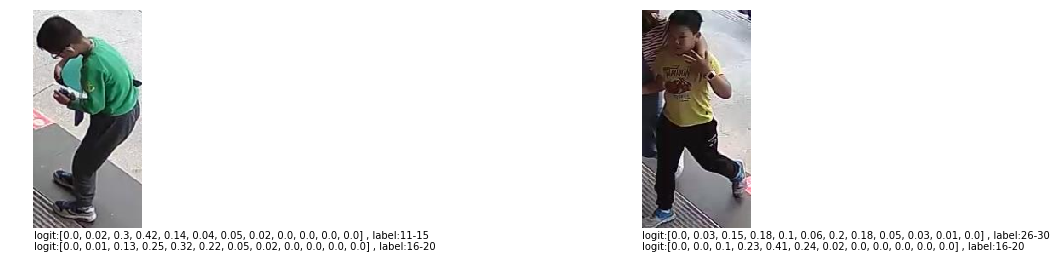

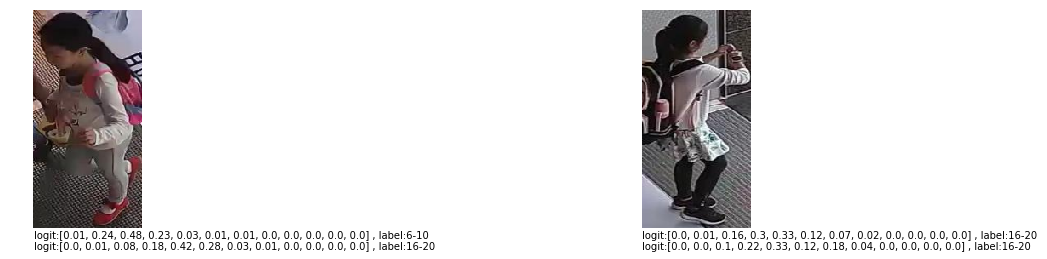

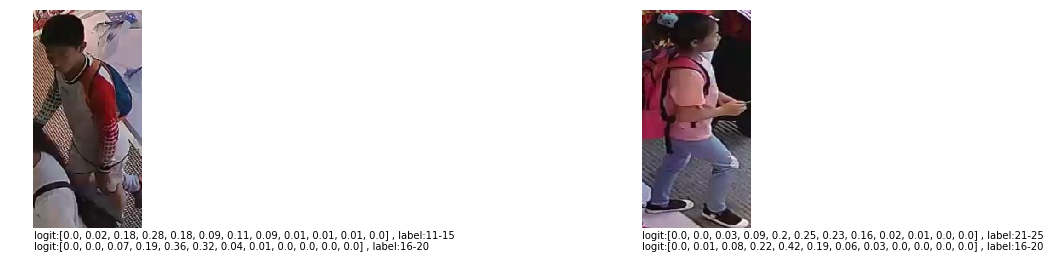

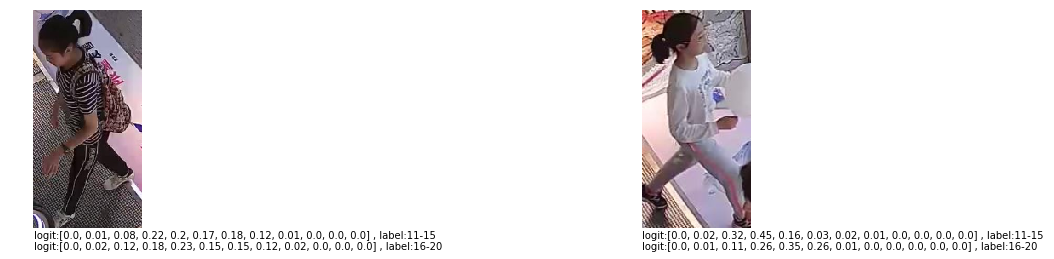

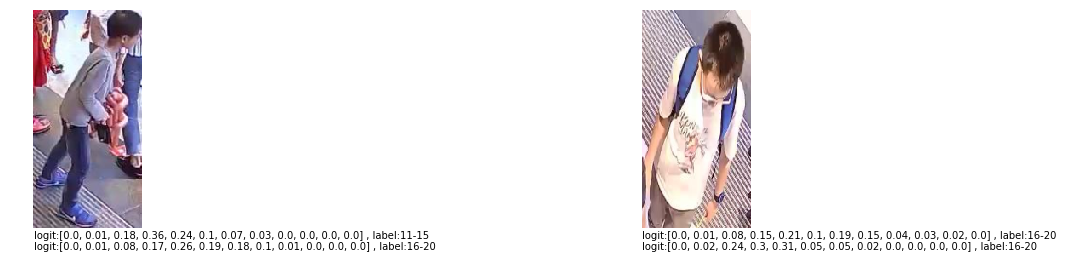

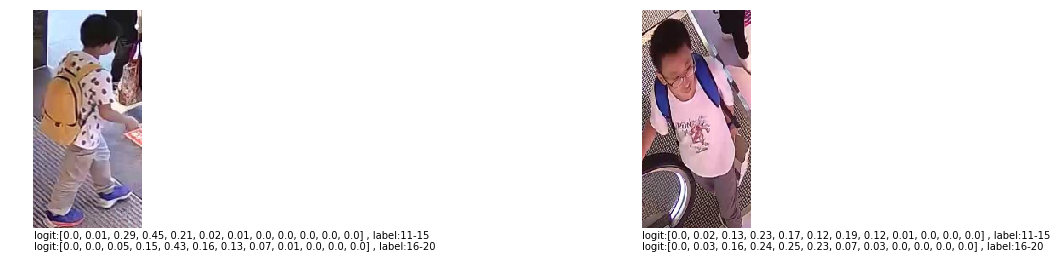

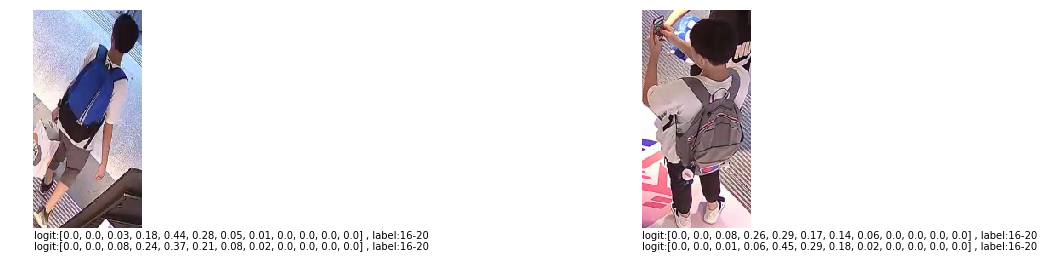

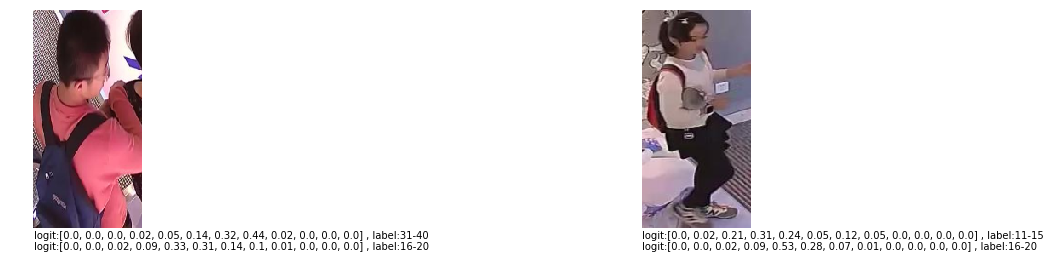

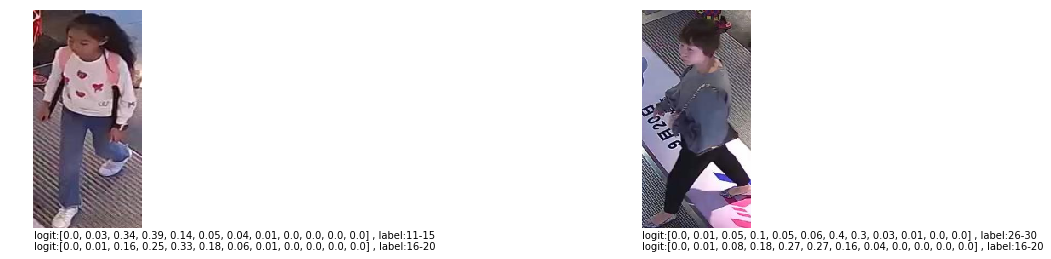

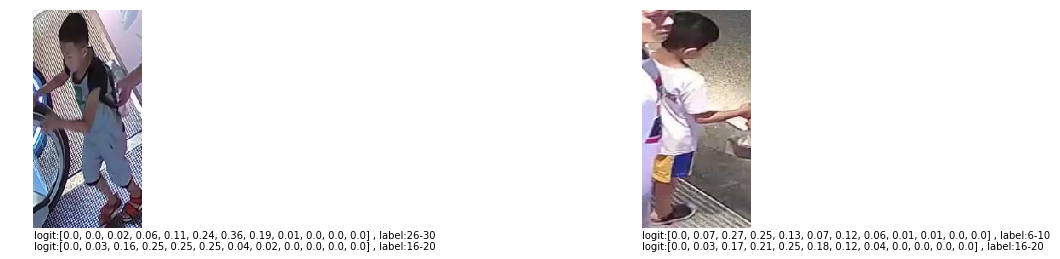

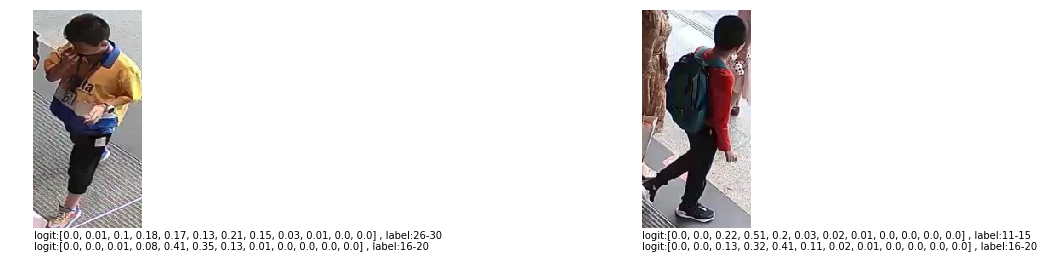

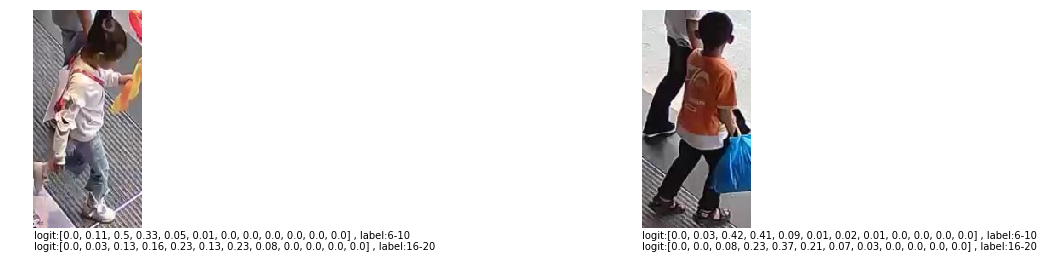

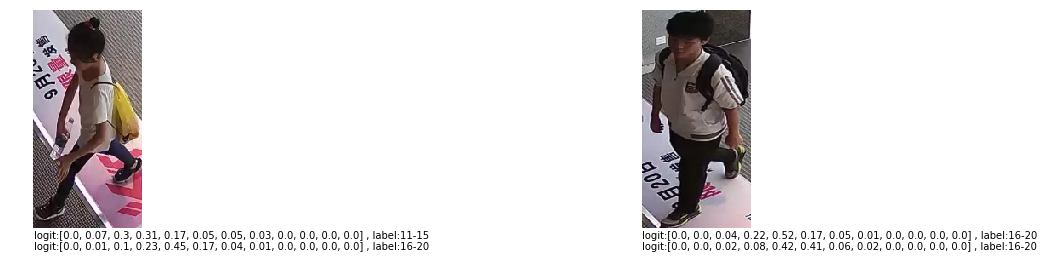

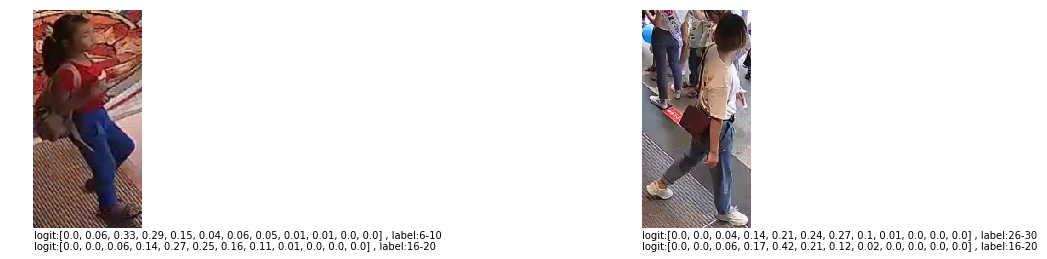

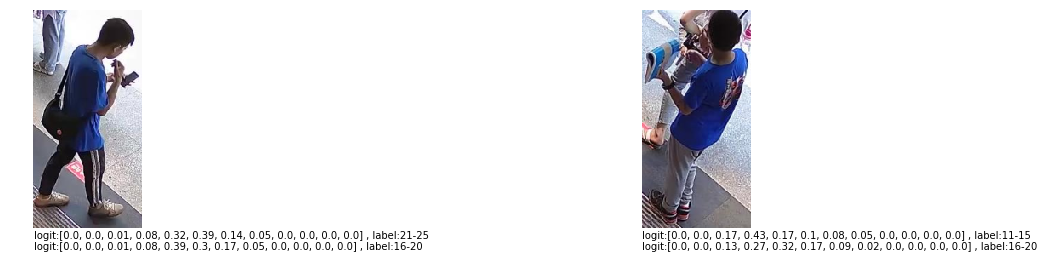

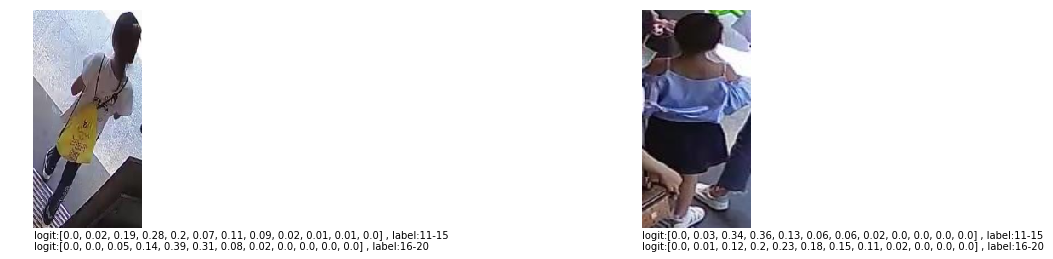

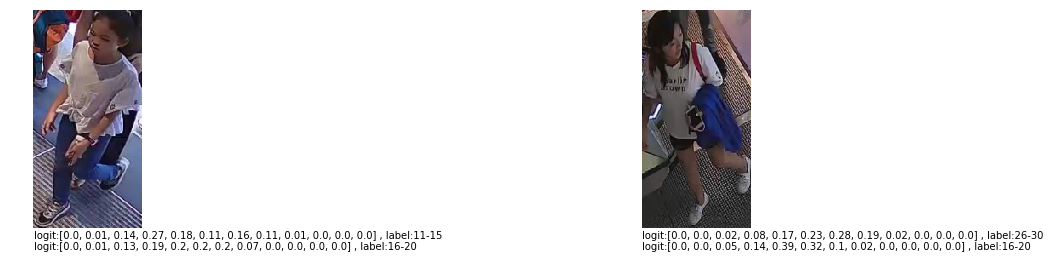

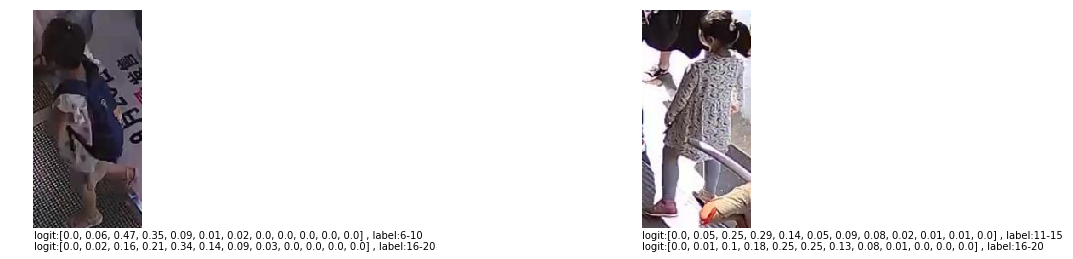

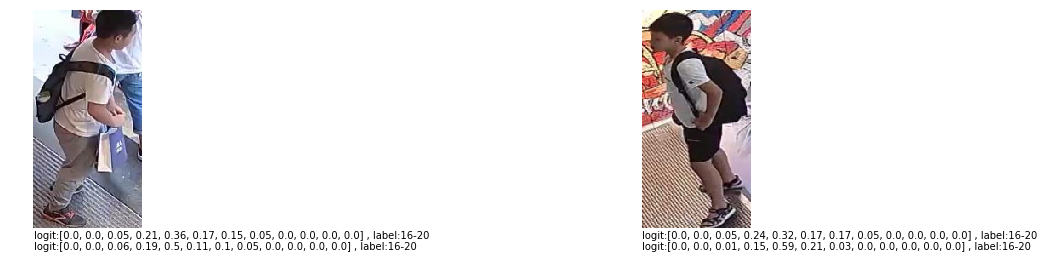

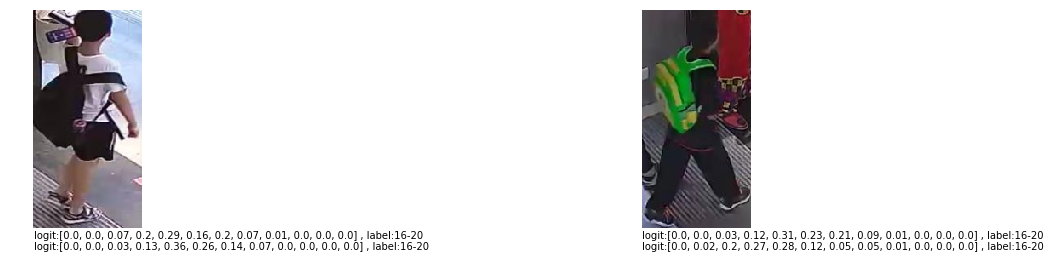

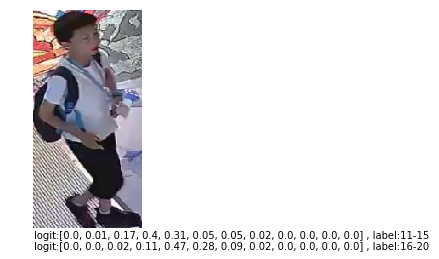

In [29]:
def distribution(scope, scope_cnt, model_name):
    plt.figure(figsize=(12,4))
    num_bins = 12
    plt.bar(scope, scope_cnt, width=0.5, color="green", align="center")
    for a, b in zip(scope, scope_cnt):
#         plt.text(a, b+0.5, '%.0f' % b, ha='center', va='bottom', fontsize=10)
        plt.text(a, b+30, '%.0f\n%.2f%%' %(b,b/sum(scope_cnt)*100), ha='center', va='bottom', fontsize=10)
    plt.xticks(range(len(scope)), scope, rotation=45)
    plt.xlabel('age distribution')
    plt.ylabel('counts')
    plt.title("%s -- %s -- total ids:%s"%(dataset_name, model_name, sum(scope_cnt)))
    plt.show()

rows = 50
cols = 2
def img_show(pred_logits_lst, pred_labels_lst):
    idx = 0
    show_cnt = 0
    for i, img in enumerate(imgs):
        if show_cnt<rows*cols and (pred_labels_lst[1][i]==scope.index("16-20")):
            if idx%cols==0:
                plt.figure(idx, figsize=(20, 4))
            plt.subplot(1, cols, show_cnt%cols+1)
            img = np.squeeze(img)[:,:,::-1]
            plt.imshow(img)
            if len(pred_logits_lst)>1:
                show_logits = [[round(k,2) for k in pred_logits_lst[j][i]] for j in range(2)]
                plt.text(0, img.shape[0]*1.1, 'logit:%s , label:%s \nlogit:%s , label:%s'
                         %(show_logits[0], age_scpoe_mapping[pred_labels_lst[0][i]],
                           show_logits[1], age_scpoe_mapping[pred_labels_lst[1][i]]))
            else:
                show_logits = [round(k,2) for k in pred_logits_lst[0][i]]
                plt.text(0, img.shape[0]*1.1, 'logit:%s , label:%s'
                         %(show_logits, age_scpoe_mapping[pred_labels_lst[0][i]]))       
            plt.axis('off')
            idx += 1
            show_cnt += 1

print("total ids: %s"%len(pred_logits_lst[0]))
for i, record_dict in enumerate(record_dict_lst):
    distribution(scope, list(record_dict.values()), model_names[i])

distribution(scope, [4,99,605,203,67,303,1694,3082,157,156,77,0], "true_value")
img_show(pred_logits_lst, pred_labels_lst)
diff_cnt = [pred_labels_lst[0][i]==pred_labels_lst[1][i] for i in range(len(pred_labels_lst[0]))]
print("total diff: %s"%Counter(diff_cnt)[False])

## open-log 分析

In [37]:
import random
wf = open("/world/data-c7/xulie/naic_reid/train_stage_1_all_query/train_all_query_cleanednew.txt", "w")
with open("/world/data-c7/xulie/naic_reid/train_stage_1_all_query/train_all_query_cleaned.txt", "r") as f:
    lst = f.readlines()
    random.shuffle(lst)
    print(len(lst))
    wf.writelines(lst)

20154
